In [893]:
import os
import pandas as pd
import requests, json

In [894]:
#Whole foods UPCS from econ_1923 GitHub
GE_WF_UPCSs = ["16000124790", "16000122543", "16000125063", "16000123991", "16000487727", "30000060834", "16000124950", "16000125933", "16000275157", "16000124998", "16000487949", "30000063224", "884912004710", "16000487932", "884912014269", "30000063545", "884912129659", "16000103719", "38000199240", "16000163461", "38000198717", "884912111715", "884912249265", "16000126855", "884912126115", "16000120259", "884912002372", "38000200458", "16000163614", "30000064306", "884912102102", "16000152335", "884912116505", "16000275638", "43000129715", "16000157811", "38000787041", "16000121836", "21908455563", "43000129517", "884912126016", "16000163669", "30000061534", "30034019082", "884912249272", "13562002474", "884912117625", "43000014271", "884912114600", "38000200663"]

In [895]:
GE_shelf = GE_WF_UPCSs

In [896]:
%run APIkeys.py

<Figure size 432x288 with 0 Axes>

# UPC Processing Funcitons

In [897]:
def checkUPC_V2(upc):
    app_id = os.environ['EDAMAM_API_id']
    key = os.environ['EDAMAM_API_key']
    baseURL = 'https://api.edamam.com/api/food-database/v2/parser?app_id='+app_id+'&app_key='+key+'&upc='
    endURL = '&nutrition-type=cooking&category=packaged-foods'
    url = baseURL + upc + endURL
    info = requests.get(url).json()
    if 'error' in info:
        return info
    else:
        answer = info['hints'][0]['food']['nutrients']
        
        sizeList = info['hints'][0]['food']['servingSizes']
        n = len(sizeList)
        for i in range(n):
            if sizeList[i]['label'] == 'Gram':
                answer['servingSize_gram'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
            if sizeList[i]['label'] == 'Cup':
                answer['servingSize_cup'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
        
        answer['label'] = info['hints'][0]['food']['label']
        answer['upc'] = upc
        return answer

In [898]:
def run_shelf(shelf, verbose = False, leftovers = False, source=""):
    
    # Shelf - a list of strings, each representing a UPC code
    # verbose - boolean telling the function whether to print found/unfound UPCs
    # leftovers - boolean telling the function whetehr to output the 
    
    found = []    #container for information on found UPCS
    unfound = []  #container for unfound UPCs
    
    # loop over UPCs in shelf
    for upc in shelf:
        info = checkUPC_V2(upc)
        
        if 'error' in info:
            unfound.append(upc) #add to the unfound container
            if verbose:
                print('UPC ',upc, ' does not exist in the API\'s data base')
        
        else:
            if verbose:
                print('UPC ',upc, ' exists in the API\'s data base')
            found.append(info)
    
    # turn the dictionary found into aDataframe
    if len(found)>0:
        df_found = pd.DataFrame(found)
    else:
        df_found = pd.DataFrame()
    
    # add a source column
    df_found["dataSource"] = pd.Series([source for i in range(len(df_found.index))])
    
    
    # return the values of found and unfound (optional)
    if leftovers:
        return df_found.head(),unfound
    else:
        return df_found.head()

In [899]:
# reading in Kaggle data from GitHub
df1 = pd.read_csv('/Users/natemcdowell/Desktop/edamamAPI_project/cereal_kaggle.csv', delimiter=',')
df1.dataframeName = 'cereal.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 77 rows and 16 columns


In [900]:
df1

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,G,C,110,2,1,250,0.0,21.0,3,60,25,3,1.0,0.75,39.106174
73,Trix,G,C,110,1,1,140,0.0,13.0,12,25,25,2,1.0,1.00,27.753301
74,Wheat Chex,R,C,100,3,1,230,3.0,17.0,3,115,25,1,1.0,0.67,49.787445
75,Wheaties,G,C,100,3,1,200,3.0,17.0,3,110,25,1,1.0,1.00,51.592193


In [863]:
#cleaning. 
df1 = df1.loc[df1["type"] !='H'] # there were 3 instances of type = 'H' so I dropped to avoid confusion
df1 = df1.drop(columns = {'mfr','type','rating',"weight","shelf"}) # drop unnecessary
df1['source'] = 'kaggle'

In [864]:
df2 = run_shelf(GE_shelf)

In [865]:
df2 = df2.rename(columns = {"label":"name",
                           "SUGAR":"sugars",
                           "FAT":"fat",
                           "FIBTG":"fiber",
                            "ENERC_KCAL":"calorie",
                            "PROCNT":"protein",
                            "K":"potass",
                            "NA":"sodium",
                            "CHOCDF":"carbo",
                            "servingSize_cup":"cups"
                           })
df2['source'] = 'edamam, whole foods'

In [866]:
df2 = df2[["name",
         "sugars",
         "fat",
         "fiber",
         "calorie",
          "protein",
          "potass",
          "sodium",
          "carbo",
          "cups",
           "source"
          ]]

In [867]:
df1.head()
df2= df2[["name","calorie","protein","fat","sodium","fiber","carbo","sugars","potass","cups", "source"]]
df1 = df1.drop(columns = {"vitamins"})

In [868]:
df2.head()

,name,calorie,protein,fat,sodium,fiber,carbo,sugars,potass,cups,source
0,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
1,Cinnamon Toast Crunch Cereal,419.000000,3.230000,9.680000,581.00000,6.500000,80.650002,29.030001,177.000000,0.75,"edamam, whole foods"
2,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
3,"Lucky Charms Cereal Frosted Toasted Oat, With ...",407.407407,7.407407,3.703704,629.62963,7.407407,81.481481,37.037037,185.185185,0.75,"edamam, whole foods"
4,Cheerios Cereal,357.000000,10.710000,7.140000,500.00000,10.700000,71.430000,3.570000,643.000000,1.00,"edamam, whole foods"


In [869]:
df1 = df1.rename(columns = {"calories":"calorie"})
df1

,name,calorie,protein,fat,sodium,fiber,carbo,sugars,potass,cups,source
0,100% Bran,70,4,1,130,10.0,5.0,6,280,0.33,kaggle
1,100% Natural Bran,120,3,5,15,2.0,8.0,8,135,1.00,kaggle
2,All-Bran,70,4,1,260,9.0,7.0,5,320,0.33,kaggle
3,All-Bran with Extra Fiber,50,4,0,140,14.0,8.0,0,330,0.50,kaggle
4,Almond Delight,110,2,2,200,1.0,14.0,8,-1,0.75,kaggle
...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,110,2,1,250,0.0,21.0,3,60,0.75,kaggle
73,Trix,110,1,1,140,0.0,13.0,12,25,1.00,kaggle
74,Wheat Chex,100,3,1,230,3.0,17.0,3,115,0.67,kaggle
75,Wheaties,100,3,1,200,3.0,17.0,3,110,1.00,kaggle


In [870]:
frames = [df1,df2]

In [871]:
result = pd.concat(frames)

In [872]:
#merged dataframe
result

,name,calorie,protein,fat,sodium,fiber,carbo,sugars,potass,cups,source
0,100% Bran,70.000000,4.000000,1.000000,130.00000,10.000000,5.000000,6.000000,280.000000,0.33,kaggle
1,100% Natural Bran,120.000000,3.000000,5.000000,15.00000,2.000000,8.000000,8.000000,135.000000,1.00,kaggle
2,All-Bran,70.000000,4.000000,1.000000,260.00000,9.000000,7.000000,5.000000,320.000000,0.33,kaggle
3,All-Bran with Extra Fiber,50.000000,4.000000,0.000000,140.00000,14.000000,8.000000,0.000000,330.000000,0.50,kaggle
4,Almond Delight,110.000000,2.000000,2.000000,200.00000,1.000000,14.000000,8.000000,-1.000000,0.75,kaggle
...,...,...,...,...,...,...,...,...,...,...,...
0,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
1,Cinnamon Toast Crunch Cereal,419.000000,3.230000,9.680000,581.00000,6.500000,80.650002,29.030001,177.000000,0.75,"edamam, whole foods"
2,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
3,"Lucky Charms Cereal Frosted Toasted Oat, With ...",407.407407,7.407407,3.703704,629.62963,7.407407,81.481481,37.037037,185.185185,0.75,"edamam, whole foods"


In [873]:
import seaborn as sns

<AxesSubplot:>

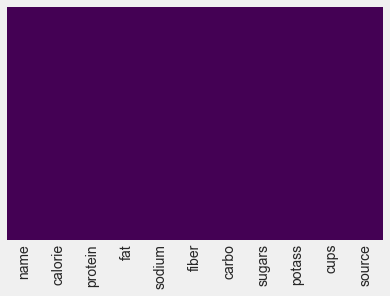

In [874]:
sns.heatmap(result.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [875]:
#set index to the name of the cereal
result.index = result.name

In [876]:
df_num = result[["calorie","protein","fat","sodium","fiber","carbo","sugars","potass"]]

In [877]:
#drop all instances outside of 3 sd from mean(outliers)
df_num =df_num[(np.abs(stats.zscore(df_num)) < 3).all(axis=1)]

In [878]:
def  rescaleFeatures(df_in):
    # This function rescale all the columns in dataframe df_in to be
    # between 0 and 1. It returns the scaled dataframe as well as the
    # lists of minimum and the maximum (so we can rescale back)

    df_out = df_in # first, we make a copy of the original df
    m = df_out.min() # a list of minimums for all columns in df_in
    M = df_out.max() # a list of maximums for all columns in df_in
    for i in range(len(df_out.columns)):
        df_out.iloc[:,i] = (df_out.iloc[:,i] - m[i])/(M[i]-m[i])
    
    return df_num,m,M
df_num,m,M = rescaleFeatures(df_num)

# Descriptive Statistics

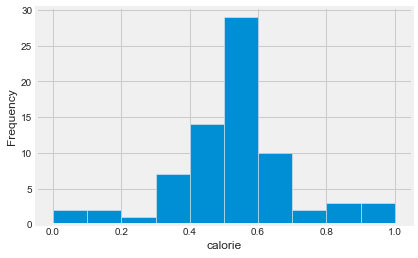

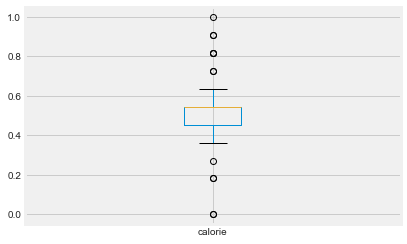

mean: 0.5267745952677462
median: 0.5454545454545454
min: 0.0
max: 1.0
stdev: 0.17072127555703534
______________________________________________________________________



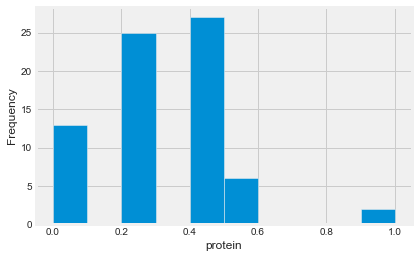

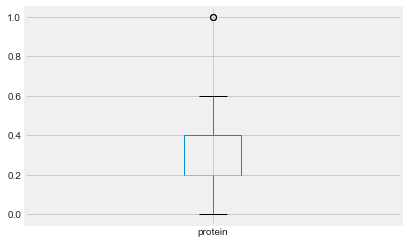

mean: 0.29315068493150664
median: 0.2
min: 0.0
max: 1.0
stdev: 0.21103499388811714
______________________________________________________________________



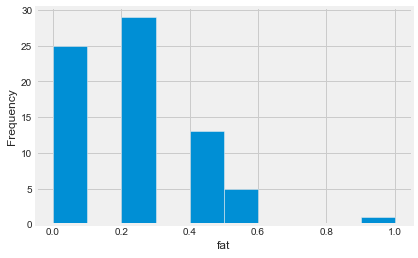

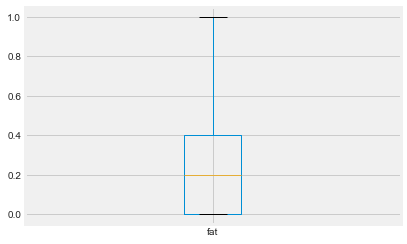

mean: 0.20547945205479434
median: 0.2
min: 0.0
max: 1.0
stdev: 0.20268366907771992
______________________________________________________________________



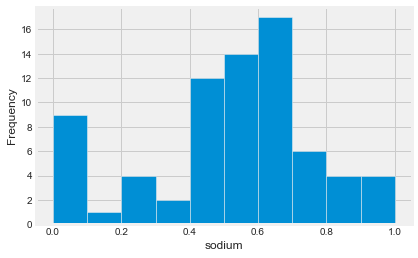

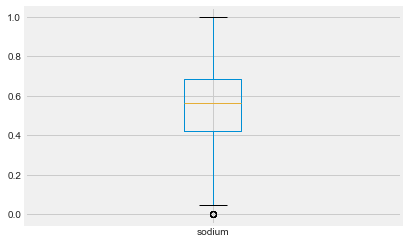

mean: 0.5169092465753424
median: 0.5625
min: 0.0
max: 1.0
stdev: 0.25355214924601155
______________________________________________________________________



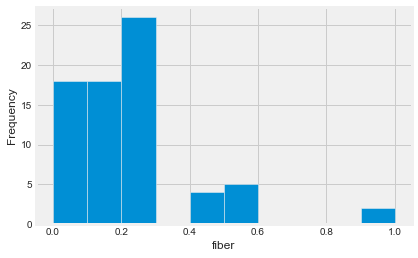

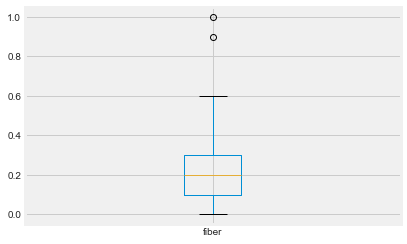

mean: 0.2027397260273973
median: 0.2
min: 0.0
max: 1.0
stdev: 0.19858709448090617
______________________________________________________________________



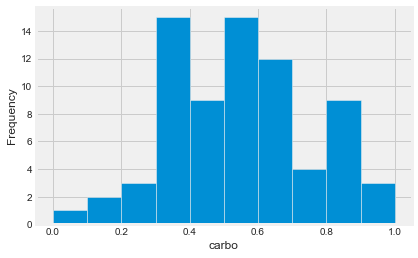

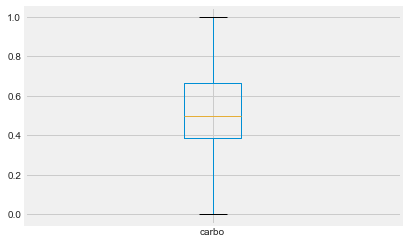

mean: 0.5441400304414004
median: 0.5
min: 0.0
max: 1.0
stdev: 0.21305531494135277
______________________________________________________________________



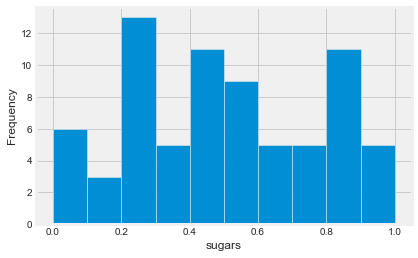

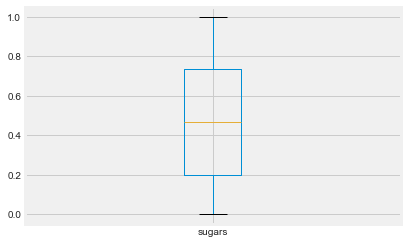

mean: 0.48493150684931513
median: 0.4666666666666667
min: 0.0
max: 1.0
stdev: 0.28528960247539387
______________________________________________________________________



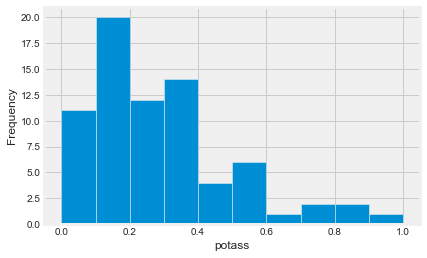

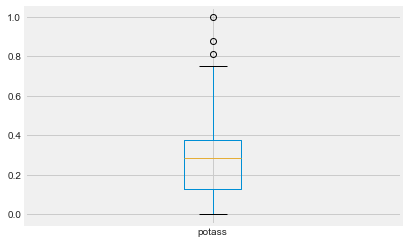

mean: 0.29603550548371954
median: 0.2834890965732087
min: 0.0
max: 1.0
stdev: 0.20819380174410354
______________________________________________________________________



In [879]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#subject = .select_dtypes(include='number')
for x in df_num:
    df_num[x].plot.hist()
    plt.xlabel(x)
    plt.show()
    df_num[x].plot.box()
    plt.show()
    print("mean:",df_num[x].mean())
    print("median:",df_num[x].median())
    print("min:",df_num[x].min())
    print("max:",df_num[x].max())
    print("stdev:",df_num[x].std())
    print("______________________________________________________________________")
    print("")

# Scatter Plots

In [880]:
#this function outputs the two factors with the highest positive correlation
target_pairs = []
for x in df_num: 
    for y in df_num:
        if 0.99 > df_num[x].corr(df_num[y]) > .8:  
            print(x,y, ":", df_num[x].corr(df_num[y]))
            target_pairs.append([x,y])
        

fiber potass : 0.9160050404663549
potass fiber : 0.9160050404663549


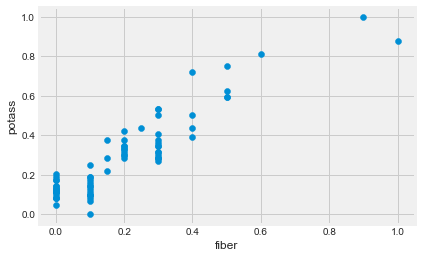

In [881]:
x = df_num['fiber']
y = df_num['potass']
plt.scatter(x, y)
plt.xlabel("fiber")
plt.ylabel("potass")
plt.show()

# K MEANS

In [932]:
k = 3
X = pd.DataFrame(df_num,columns=['fiber','potass'])

In [933]:
kmeans = KMeans(init="random",
                n_clusters=k,
                n_init=10,
                max_iter=300,
                random_state=42
               )
kmeans.fit(X)

KMeans(init='random', n_clusters=3, random_state=42)

In [937]:
kmeans.inertia_

0.9780405415894666

### Inertia  
Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. The optimal result for a K means is a low inertia paired with a low k value(# of clusters).

In [935]:
kmeans.cluster_centers_

array([[0.26612903, 0.36237564],
       [0.04852941, 0.12946674],
       [0.6125    , 0.74688474]])

In [939]:
kmeans.n_iter_

5

In [940]:
#number of kmeans it took for the cluster centers to settle(be at their optimal location)

In [922]:
centers = np.array(kmeans.cluster_centers_)

Text(0.5, 1.0, 'k means centroids')

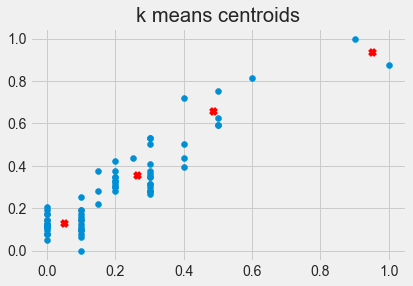

In [923]:
plt.scatter(X.fiber, X.potass)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')
plt.plot()
plt.title('k means centroids')

In [924]:
kmeans.labels_[:5]

array([2, 3, 2, 0, 0], dtype=int32)

In [925]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
     "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

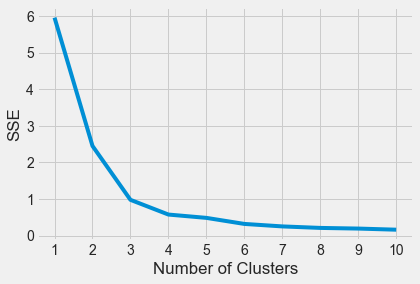

In [926]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [931]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

In [ ]:
# The *elbow* can be interpreted as the number of clusters that categorizes the dasta most efficienttly. 

In [928]:
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

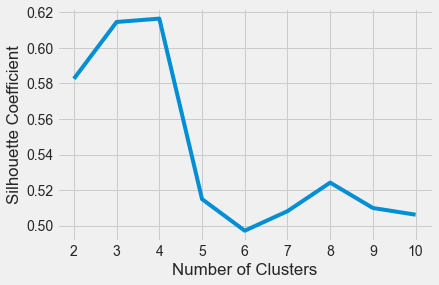

In [930]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
#According to the Silhouette Coefficent the optimal number of clusters is between 3 and 4. 

# resources
I used https://realpython.com/k-means-clustering-python/ to run the kmeans

### Conclusion

The first step in this project was determining what data to include. Our group used the resources provided on the Econ 1923 Github project to complete this project: the list of Giant Eagle UPCs, and the CSV sheet of cereal prodcuts. We made an API call to Edamam API based to garner data that we used to create *df1*. We then converted the CSV file into another dataframe *df2*. The process of cleaning was mostly just deciding what features to keep from each dataset. We ended up keeping, "name","calorie","protein","fat","sodium","fiber","carbo","sugars","potass","cups", and "source" as our features as this was what each dataset had in common.  By combinging df1 and df2 together, we have a 79 rows × 11 columns dataframe. Based on the box plots for each factor above, the mean, median, minimum, max, standard deviation, and the distribution pattern can be seen directly.For data visualization part, we used the correlation function and found that fiber and potass have the highest positive correlated relationship (0.916).Moving on to K-means method application that analyzes the degree of product differentiation, as the number of clusters increases, the total sum of errors (SSE) decreases and approaches to 0. As the value of K increases, there will be fewer elements in the cluster. So average distortion will decrease. The lesser number of elements means closer to the centroid. The value of the silhouette coefﬁcient is between [-1, 1]. A score of 1 denotes the best outcome that the data point i is very compact within the cluster to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters.When k = 3 or 4, the silhoutte coefficient is closet to 1. The cereal market, based on our findings, is NOT saturated because only certain nutrition factors are correlated among different products, which implies that each product is still able to differntiate itself from other competitors.